# 第9章: 事前学習済み言語モデル（BERT型）

本章では、BERT型の事前学習済みモデルを利用して、マスク単語の予測や文ベクトルの計算、評判分析器（ポジネガ分類器）の構築に取り組む。

In [1]:
!pip install transformers

In [2]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from transformers import BertModel, BertForMaskedLM, BertTokenizer
from torch.utils.data import Dataset, DataLoader

In [3]:
%%capture
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForMaskedLM.from_pretrained(model_name)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
#tokenizer info
print(tokenizer.vocab_size)
print(tokenizer.model_max_length)
print(tokenizer.model_input_names)
print(tokenizer.cls_token)
print(tokenizer.sep_token)
print(tokenizer.pad_token)
print(tokenizer.unk_token)
print(tokenizer.mask_token)

30522
512
['input_ids', 'token_type_ids', 'attention_mask']
[CLS]
[SEP]
[PAD]
[UNK]
[MASK]


## 80. トークン化

"The movie was full of incomprehensibilities."という文をトークンに分解し、トークン列を表示せよ。

In [5]:
text_80 = "The movie was full of incomprehensibilities."

tokenized_text_80 = tokenizer(text_80)
print(tokenized_text_80)

{'input_ids': [101, 1996, 3185, 2001, 2440, 1997, 4297, 25377, 2890, 10222, 5332, 14680, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


## 81. マスクの予測

"The movie was full of [MASK]."の"[MASK]"を埋めるのに最も適切なトークンを求めよ。

In [6]:
special_tokens = ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]']

for token in special_tokens:
    token_id = tokenizer.convert_tokens_to_ids(token)
    print(f"{token}: {token_id}")

[PAD]: 0
[UNK]: 100
[CLS]: 101
[SEP]: 102
[MASK]: 103


In [7]:
text_81 = "The movie was full of [MASK]."

inputs = tokenizer(text_81, return_tensors="pt")

mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
print(inputs)
print(mask_token_index)

with torch.no_grad():
    outputs = model(**inputs)
    print(outputs.logits.shape)#torch.Size([1, 9, 30522]) バッチサイズ　トークン数　語彙
    logits = outputs.logits

mask_logits = logits[0, mask_token_index, :]
print(mask_logits.shape)

top_token_id = torch.argmax(mask_logits, dim=1) #各行における最大値のインデックスを返すからdim=1ってことかな？
print(f"top_token_id:{top_token_id}")

predicted_token = tokenizer.convert_ids_to_tokens(top_token_id)

print(f"Predicted token: {predicted_token}")


{'input_ids': tensor([[ 101, 1996, 3185, 2001, 2440, 1997,  103, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}
tensor([6])
torch.Size([1, 9, 30522])
torch.Size([1, 30522])
top_token_id:tensor([4569])
Predicted token: ['fun']


## 82. マスクのtop-k予測

"The movie was full of [MASK]."の"[MASK]"に埋めるのに適切なトークン上位10個と、その確率（尤度）を求めよ。

In [8]:
text_82 = "The movie was full of [MASK]."

inputs = tokenizer(text_82, return_tensors="pt")

mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]

with torch.no_grad():
    outputs = model(**inputs)
    print(outputs.logits.shape)#torch.Size([1, 9, 30522]) バッチサイズ　トークン数　語彙
    logits = outputs.logits

mask_logits = logits[0, mask_token_index[0], :] #shape: [vocab_size]

mask_logits_prob = F.softmax(mask_logits, dim=0)
print(mask_logits.shape)
print(mask_logits)
print(mask_logits_prob.shape)
print(mask_logits_prob)

topk = torch.topk(mask_logits_prob, k=10)

for idx, score in zip(topk.indices, topk.values):
  token = tokenizer.convert_ids_to_tokens(idx.item())
  print(f"{token}: {score.item():.2f}")

torch.Size([1, 9, 30522])
torch.Size([30522])
tensor([-3.6503, -3.4497, -3.2653,  ..., -3.2588, -2.6857, -4.3190])
torch.Size([30522])
tensor([2.5729e-07, 3.1443e-07, 3.7810e-07,  ..., 3.8057e-07, 6.7506e-07,
        1.3182e-07])
fun: 0.11
surprises: 0.07
drama: 0.04
stars: 0.03
laughs: 0.03
action: 0.02
excitement: 0.02
people: 0.02
tension: 0.02
music: 0.01


## 83. CLSトークンによる文ベクトル

以下の文の全ての組み合わせに対して、最終層の[CLS]トークンの埋め込みベクトルを用いてコサイン類似度を求めよ。

- "The movie was full of fun."
- "The movie was full of excitement."
- "The movie was full of crap."
- "The movie was full of rubbish."


In [9]:
def cosine_similarity_matrix(x):
  '''
  arg shape: [batch_size, hidden_size]
  return shape: [batch_size, batch_size]
  '''
  x_norm = x / x.norm(dim=1, keepdim=True) #dim=1に対して正規化

  return torch.matmul(x_norm, x_norm.T) #[batch_size, hidden_size] . [hidden_size, batch_size] 内積とってる


In [10]:
model = BertModel.from_pretrained(model_name)

sentences = ["The movie was full of fun.",
             "The movie was full of excitement.",
             "The movie was full of crap.",
             "The movie was full of rubbish."]

inputs = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True) #padding=Trueにしたから，seq_lenがbatchの中で一番大きいものに統一される

with torch.no_grad():
  outputs = model(**inputs)
  last_hidden_state = outputs.last_hidden_state #shape: [batch_size, sequence_length, hidden_size]

print(last_hidden_state.shape)
cls_last_hidden_state = last_hidden_state[:,0,:] #shape [batch_size, hidden_size]
cosine_similarity = cosine_similarity_matrix(cls_last_hidden_state)

df = pd.DataFrame(
    cosine_similarity.numpy(),
    columns=sentences,
    index=sentences,
)
pd.set_option("display.precision", 3) #少数第3位までにできるっぽい

df

torch.Size([4, 9, 768])


,The movie was full of fun.,The movie was full of excitement.,The movie was full of crap.,The movie was full of rubbish.
The movie was full of fun.,1.000,0.988,0.956,0.948
The movie was full of excitement.,0.988,1.000,0.954,0.949
The movie was full of crap.,0.956,0.954,1.000,0.981
The movie was full of rubbish.,0.948,0.949,0.981,1.000


## 84. 平均による文ベクトル

以下の文の全ての組み合わせに対して、最終層の埋め込みベクトルの平均を用いてコサイン類似度を求めよ。

- "The movie was full of fun."
- "The movie was full of excitement."
- "The movie was full of crap."
- "The movie was full of rubbish."

In [41]:
model = BertModel.from_pretrained(model_name)

sentences = ["The movie was full of fun.",
             "The movie was full of excitement.",
             "The movie was full of crap.",
             "The movie was full of rubbish."]

inputs = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True) #padding=Trueにしたから，seq_lenがbatchの中で一番大きいものに統一される

with torch.no_grad():
  outputs = model(**inputs)
  last_hidden_state = outputs.last_hidden_state #shape: [batch_size, sequence_length, hidden_size]

attention_mask = inputs["attention_mask"] #attention_mask

mask = attention_mask.unsqueeze(-1).float()
print(mask.shape) #shape: [batch_size, seq_len, 1]

masked_hidden = last_hidden_state * mask  # パディング部分がゼロになる
print(masked_hidden.shape) #shape: [batch_size, seq_len, hidden_size]

# 各文ごとの実トークン数（=attention_maskの合計）
lengths = mask.sum(dim=1)  # shape: [batch_size, 1]

last_hidden_state_mean = masked_hidden.sum(dim=1) / lengths

cosine_similarity = cosine_similarity_matrix(last_hidden_state_mean)


df = pd.DataFrame(
    cosine_similarity.numpy(),
    columns=sentences,
    index=sentences,
)
pd.set_option("display.precision", 3) #少数第3位までにできるっぽい

df

torch.Size([4, 9, 1])
torch.Size([4, 9, 768])


,The movie was full of fun.,The movie was full of excitement.,The movie was full of crap.,The movie was full of rubbish.
The movie was full of fun.,1.000,0.957,0.849,0.817
The movie was full of excitement.,0.957,1.000,0.835,0.794
The movie was full of crap.,0.849,0.835,1.000,0.923
The movie was full of rubbish.,0.817,0.794,0.923,1.000


## 85. データセットの準備

[General Language Understanding Evaluation (GLUE)](https://gluebenchmark.com/) ベンチマークで配布されている[Stanford Sentiment Treebank (SST)](https://dl.fbaipublicfiles.com/glue/data/SST-2.zip) から訓練セット（train.tsv）と開発セット（dev.tsv）のテキストと極性ラベルと読み込み、さらに全てのテキストはトークン列に変換せよ。

In [12]:
%%capture
!wget https://dl.fbaipublicfiles.com/glue/data/SST-2.zip
!unzip SST-2.zip

In [13]:
import pandas as pd

# データの読み込み
train_df = pd.read_csv("SST-2/train.tsv", sep='\t', )
dev_df = pd.read_csv("SST-2/dev.tsv", sep='\t', )

In [14]:
train_df

,sentence,label
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates som...,1
3,remains utterly satisfied to remain the same t...,0
4,on the worst revenge-of-the-nerds clichés the ...,0
...,...,...
67344,a delightful comedy,1
67345,"anguish , anger and frustration",0
67346,"at achieving the modest , crowd-pleasing goals...",1
67347,a patient viewer,1


In [15]:
!pip install matplotlib seaborn

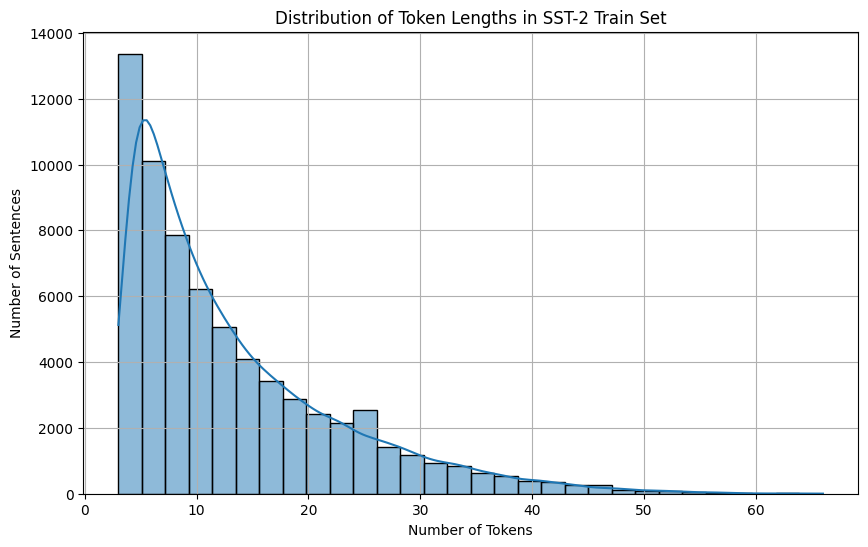

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer
import pandas as pd


# 各文をトークナイズし、トークン数を記録
token_lengths = []

for sentence in train_df['sentence']:
    tokens = tokenizer.encode(sentence, add_special_tokens=True)
    token_lengths.append(len(tokens))

# 可視化
plt.figure(figsize=(10, 6))
sns.histplot(token_lengths, bins=30, kde=True)
plt.title("Distribution of Token Lengths in SST-2 Train Set")
plt.xlabel("Number of Tokens")
plt.ylabel("Number of Sentences")
plt.grid(True)
plt.show()

#生成AIに作らせました

In [17]:
class SST2Dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sentence = self.data.iloc[index]['sentence']
        label = int(self.data.iloc[index]['label'])

        encoding = self.tokenizer(
            sentence,
            truncation=True,#max_lengthよりも長い場合に自動的にトリミングするようにしてる
            padding='max_length', #入力文がmax_lengthに満たない時に[PAD]を追加して長さを揃える
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0), #__getitem__()は１つのサンプルを返す関数だからバッチ次元を取り除いた方がいいっぽい
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

# 3. Datasetの作成
train_dataset = SST2Dataset(train_df, tokenizer)
dev_dataset = SST2Dataset(dev_df, tokenizer)

In [18]:
ex = train_dataset.__getitem__(0)
ex

{'input_ids': tensor([  101,  5342,  2047,  3595,  8496,  2013,  1996, 18643,  3197,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

## 86. ミニバッチの作成

85で読み込んだ訓練データの一部（例えば冒頭の4事例）に対して、パディングなどの処理を行い、トークン列の長さを揃えてミニバッチを構成せよ。

In [24]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=64, shuffle=False)

i = 0
for data in train_dataloader:
    print(data["input_ids"].shape) #shape: [batch_size, max_length]
    print(data['label'].shape) #shape:[batch_size]
    print(data)
    i = i+1
    if i > 0:
      break #確認してみた

torch.Size([64, 128])
torch.Size([64])
{'input_ids': tensor([[  101,  3005, 10106,  ...,     0,     0,     0],
        [  101,  2028,  1997,  ...,     0,     0,     0],
        [  101,  1037, 29321,  ...,     0,     0,     0],
        ...,
        [  101,  4895, 22852,  ...,     0,     0,     0],
        [  101,  2087,  2139,  ...,     0,     0,     0],
        [  101,  2097,  2022,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'label': tensor([1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
        1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0])}


## 87. ファインチューニング

訓練セットを用い、事前学習済みモデルを極性分析タスク向けにファインチューニングせよ。検証セット上でファインチューニングされたモデルの正解率を計測せよ。

In [20]:
import torch
import torch.nn as nn
from transformers import BertModel
from torch.optim import Adam

class BertClassifier(nn.Module):
  def __init__(self, model_name, mlp_hidden_size=256, num_labels=2, dropout_rate=0.3):
    super(BertClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(model_name)
    self.dropout = nn.Dropout(dropout_rate)
    self.classifier = nn.Sequential(
        nn.Linear(self.bert.config.hidden_size, mlp_hidden_size),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(mlp_hidden_size, num_labels)
    )
  def forward(self, input_ids, attention_mask, token_type_ids=None, labels=None):
    bert_outputs = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids
    )
    cls_output = bert_outputs.last_hidden_state[:, 0, :]
    cls_output = self.dropout(cls_output)
    logits = self.classifier(cls_output)

    loss = None
    if labels is not None:
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(logits, labels)

    return loss, logits




In [21]:
from transformers import Trainer

model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = Adam(model.parameters(), lr=1e-4)
bert_cls = BertClassifier(model_name).to(device)

In [22]:
for epoch in range(1):
    bert_cls.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in tqdm(train_dataloader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        loss, logits = bert_cls(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {acc:.4f}")


100%|██████████| 1053/1053 [21:36<00:00,  1.23s/it]

Epoch 1, Loss: 742.6003, Accuracy: 0.4672


In [23]:
from torch.utils.data import DataLoader
from tqdm import tqdm

bert_cls.eval()
total = 0
correct = 0

with torch.no_grad():
    for batch in tqdm(dev_dataloader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # forward実行
        _, logits = bert_cls(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(logits, dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

dev_acc = correct / total
print(f"Dev Accuracy: {dev_acc:.4f}")


100%|██████████| 14/14 [00:06<00:00,  2.17it/s]

Dev Accuracy: 0.4828


## 88. 極性分析

問題87でファインチューニングされたモデルを用いて、以下の文の極性を予測せよ。

- "The movie was full of incomprehensibilities."
- "The movie was full of fun."
- "The movie was full of excitement."
- "The movie was full of crap."
- "The movie was full of rubbish."


In [37]:
sentences_88 = ["The movie was full of incomprehensibilities.",
                "The movie was full of fun.",
                "The movie was full of excitement.",
                "The movie was full of crap.",
                "The movie was full of rubbish."
                ]

inputs = tokenizer(sentences_88, return_tensors="pt", padding=True, truncation=True) #padding=Trueにしたから，seq_lenがbatchの中で一番大きいものに統一される
inputs = inputs.to(device)

bert_cls.eval()

with torch.no_grad():
  logits = bert_cls(**inputs)

print(logits)
preds = torch.argmax(logits[1], dim=1)
print(preds)


(None, tensor([[0.1296, 0.0657],
        [0.1174, 0.0206],
        [0.1311, 0.0091],
        [0.0944, 0.0365],
        [0.1130, 0.0286]], device='cuda:0'))
tensor([0, 0, 0, 0, 0], device='cuda:0')


## 89. アーキテクチャの変更

問題87とは異なるアーキテクチャ（例えば[CLS]トークンを用いるか、各トークンの最大値プーリングを用いるなど）の分類モデルを設計し、事前学習済みモデルを極性分析タスク向けにファインチューニングせよ。検証セット上でファインチューニングされたモデルの正解率を計測せよ。

In [42]:
class BertClassifier_DX(nn.Module):
    def __init__(self, model_name, mlp_hidden_size=256, num_labels=2, dropout_rate=0.3):
        super(BertClassifier_DX, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, mlp_hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(mlp_hidden_size, num_labels)
        )

    def forward(self, input_ids, attention_mask, token_type_ids=None, labels=None):
        bert_outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        hidden_states = bert_outputs.last_hidden_state  # shape: [B, L, H]

        # attention_mask: [B, L] → [B, L, 1]
        mask = attention_mask.unsqueeze(-1).float()

        mask[:, 0, :] = 0  # CLS
        for i, seq_len in enumerate(attention_mask.sum(dim=1)):
            mask[i, seq_len - 1, :] = 0  # SEP

        masked_hidden = hidden_states * mask  # shape: [B, L, H]
        lengths = mask.sum(dim=1)  # shape: [B, 1]

        pooled_output = masked_hidden.sum(dim=1) / lengths  # 平均プーリング

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)

        return loss, logits


In [43]:
from transformers import Trainer

model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = Adam(model.parameters(), lr=1e-4)
bert_cls_dx = BertClassifier_DX(model_name).to(device)

In [ ]:
for epoch in range(1):
    bert_cls_dx.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in tqdm(train_dataloader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        loss, logits = bert_cls_dx(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {acc:.4f}")


In [44]:
from torch.utils.data import DataLoader
from tqdm import tqdm

bert_cls_dx.eval()
total = 0
correct = 0

with torch.no_grad():
    for batch in tqdm(dev_dataloader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # forward実行
        _, logits = bert_cls_dx(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(logits, dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

dev_acc = correct / total
print(f"Dev Accuracy: {dev_acc:.4f}")


100%|██████████| 14/14 [00:06<00:00,  2.18it/s]

Dev Accuracy: 0.4920
